In [3]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
from tqdm import tqdm
import torch
import gc
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import nltk
from torch.cuda.amp import autocast, GradScaler

In [4]:
# import the cuurent state of dataframes
df1 = pd.read_csv("../../data/instagram_data/captions_csv.csv", low_memory=False)
df2 = pd.read_csv("../../data/instagram_data2/captions_csv2.csv", low_memory=False)

In [5]:
df1 = df1.drop(columns=['Sr No'])

df1["Image File"] = "../../data/instagram_data/" + df1["Image File"] + ".jpg"

In [6]:
df2 = df2.drop(df2.columns[0], axis=1)

first_row = pd.DataFrame([df2.columns.tolist()])
first_row.columns = ["Image File", "Caption"]

df2.columns = first_row.columns
df2 = pd.concat([first_row, df2], ignore_index=True)

df2["Image File"] = "../../data/instagram_data2/" + df2["Image File"] + ".jpg"


In [7]:
df = pd.concat([df1, df2], ignore_index=True)

df = df.dropna(subset=["Caption"])

In [8]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df['Fold'] = np.tile(np.arange(5), int(np.ceil(len(df) / 5)))[:len(df)]

In [9]:
df["Fold"].value_counts(dropna= False)

Fold
0    6303
1    6303
2    6302
3    6302
4    6302
Name: count, dtype: int64

In [10]:
# create dataframe

class BLIPCaptionDataset(Dataset):
    def __init__(self, dataframe, processor, max_length=64):
        self.data = dataframe.reset_index(drop=True)
        self.prefix_text = "a picture of" 
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.loc[idx, "Image File"]
        caption = self.data.loc[idx, "Caption"]
        image = Image.open(image_path).convert("RGB")

        # 🔥 THIS is the correct usage for BLIP
        processed = self.processor(
            images=image,
            text=self.prefix_text,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length
        )

        # Labels are still the actual caption
        label_encoding = self.processor.tokenizer(
            caption,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length
        )


        return {
            "pixel_values": processed["pixel_values"].squeeze(0),
            "input_ids": processed["input_ids"].squeeze(0),   # constant prompt
            "labels": label_encoding["input_ids"].squeeze(0)  # actual caption
        }

In [18]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large", use_fast = True)
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to("cuda")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4219261..2.0321367].


tensor([  101,  2919,  7743,   999,  2008,  1005,  1055,  2129,  2017,  2191,
         2019,  4211,  1012,  1001, 18051,  3900, 13327,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])

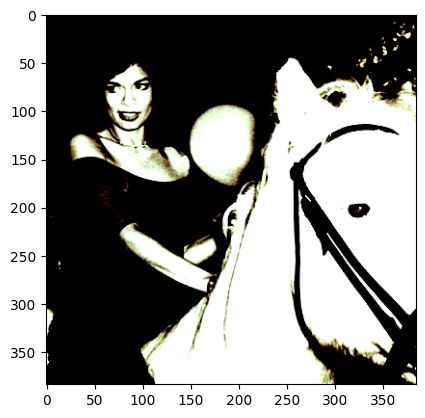

In [13]:
img = BLIPCaptionDataset(df, processor)[700]['pixel_values']
plt.imshow(np.transpose(img.numpy(), (1,2,0)))
BLIPCaptionDataset(df, processor)[700]['labels']
# BLIPCaptionDataset(df, processor)[700]['input_ids']

In [50]:

smoothie = SmoothingFunction().method4
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

scaler = GradScaler()

def train_loop_fn(data_loader, model, processor, optimizer, device, scheduler=None):
    model.train()
    running_loss = 0.0

    bleu1s, bleu2s, bleu3s, bleu4s, rougeLs = [], [], [], [], []

    tqdm_ob = tqdm(data_loader, total=len(data_loader), desc="Training")

    for batch_idx, batch in enumerate(tqdm_ob):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(pixel_values=pixel_values, input_ids=labels, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if scheduler:
            scheduler.step()

        running_loss += loss.item()
        avg_loss = running_loss / (batch_idx + 1)

        # 🧠 Evaluation: generate captions (greedy decoding)
        with torch.no_grad():
            generated_ids = model.generate(pixel_values=pixel_values, max_length=128)
            generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
            reference_texts = processor.batch_decode(labels, skip_special_tokens=True)

            for ref, hyp in zip(reference_texts, generated_texts):
                ref_tokens = nltk.word_tokenize(ref.lower())
                hyp_tokens = nltk.word_tokenize(hyp.lower())

                bleu1s.append(sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothie))
                bleu2s.append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie))
                bleu3s.append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie))
                bleu4s.append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie))

                rougeL = rouge.score(ref, hyp)["rougeL"].fmeasure
                rougeLs.append(rougeL)

        tqdm_ob.set_postfix({
            "loss": avg_loss,
            "bleu1": sum(bleu1s)/len(bleu1s),
            "bleu4": sum(bleu4s)/len(bleu4s),
            "rougeL": sum(rougeLs)/len(rougeLs),
        })

        del pixel_values, input_ids, labels
        torch.cuda.empty_cache()
        gc.collect()

    return {
        "train_loss": avg_loss,
        "bleu1": sum(bleu1s) / len(bleu1s),
        "bleu2": sum(bleu2s) / len(bleu2s),
        "bleu3": sum(bleu3s) / len(bleu3s),
        "bleu4": sum(bleu4s) / len(bleu4s),
        "rougeL": sum(rougeLs) / len(rougeLs),
    }


C:\Users\user\AppData\Local\Temp\ipykernel_22272\3607390423.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [51]:
def eval_loop_fn(data_loader, model, processor, device):
    model.eval()
    running_loss = 0.0

    bleu1s, bleu2s, bleu3s, bleu4s, rougeLs = [], [], [], [], []

    tqdm_ob = tqdm(data_loader, total=len(data_loader), desc="Evaluating")

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm_ob):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(pixel_values=pixel_values, input_ids=labels, labels=labels)
            loss = outputs.loss

            running_loss += loss.item()
            avg_loss = running_loss / (batch_idx + 1)

            # Generate captions
            generated_ids = model.generate(pixel_values=pixel_values, max_length=128)
            generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
            reference_texts = processor.batch_decode(labels, skip_special_tokens=True)

            for ref, hyp in zip(reference_texts, generated_texts):
                ref_tokens = nltk.word_tokenize(ref.lower())
                hyp_tokens = nltk.word_tokenize(hyp.lower())

                bleu1s.append(sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothie))
                bleu2s.append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie))
                bleu3s.append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie))
                bleu4s.append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie))

                rougeL = rouge.score(ref, hyp)["rougeL"].fmeasure
                rougeLs.append(rougeL)

            tqdm_ob.set_postfix({
                "val_loss": avg_loss,
                "bleu1": sum(bleu1s)/len(bleu1s),
                "bleu4": sum(bleu4s)/len(bleu4s),
                "rougeL": sum(rougeLs)/len(rougeLs),
            })

            del pixel_values, input_ids, labels
            torch.cuda.empty_cache()
            gc.collect()
            
    return {
        "val_loss": avg_loss,
        "bleu1": sum(bleu1s) / len(bleu1s),
        "bleu2": sum(bleu2s) / len(bleu2s),
        "bleu3": sum(bleu3s) / len(bleu3s),
        "bleu4": sum(bleu4s) / len(bleu4s),
        "rougeL": sum(rougeLs) / len(rougeLs),
    }

In [ ]:
def run():
    # Set constants
    EPOCHS = 2
    TRAIN_BATCH_SIZE = 2
    VALID_BATCH_SIZE = 2
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=2, T_mult=1, eta_min=1e-6, last_epoch=-1
    )

    for fold in range(1, 6):
        print("*" * 20, f"FOLD NUMBER {fold}", "*" * 20)
        df_train = df[df['Fold'] != fold].reset_index(drop=True)
        df_valid = df[df['Fold'] == fold].reset_index(drop=True)

        train_dataset = BLIPCaptionDataset(df_train, processor)
        valid_dataset = BLIPCaptionDataset(df_valid, processor)

        train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
        val_loader = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False, num_workers=4)

        for epoch in range(EPOCHS):
            print(f"Epoch --> {epoch + 1} / {EPOCHS}")
            print("-------------------------------")
            train_metrics = train_loop_fn(train_loader, model, processor, optimizer, DEVICE, scheduler)
            print("Training Loss & Metrics:")
            print(train_metrics)

            val_metrics = eval_loop_fn(val_loader, model, processor, DEVICE)
            print("Validation Loss & Metrics:")
            print(val_metrics)

        print("\n")

    torch.save(model.state_dict(), './best_blip_large_captioning_model.pt')


if __name__ == "__main__":
    run()

******************** FOLD NUMBER 1 ********************
Epoch --> 1 / 2
-------------------------------


Training:   0%|          | 0/12604 [00:00<?, ?it/s]